In [65]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [57]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test  = pd.read_csv("test.csv", parse_dates=["date"])

print(train.head())
print(test.head())
print(train.info())
print(train.isna().sum())
print(test.isna().sum())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
date     0
store    0
item     0
sales    0
dtype: int64
id       0
date     0
store    0
item     0
dtype: int64


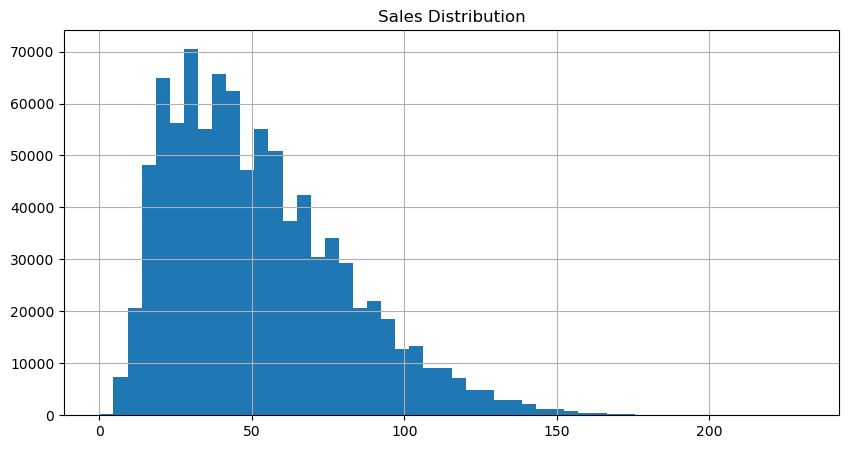

In [3]:
import matplotlib.pyplot as plt

train["sales"].hist(bins=50, figsize=(10,5))
plt.title("Sales Distribution")
plt.show()


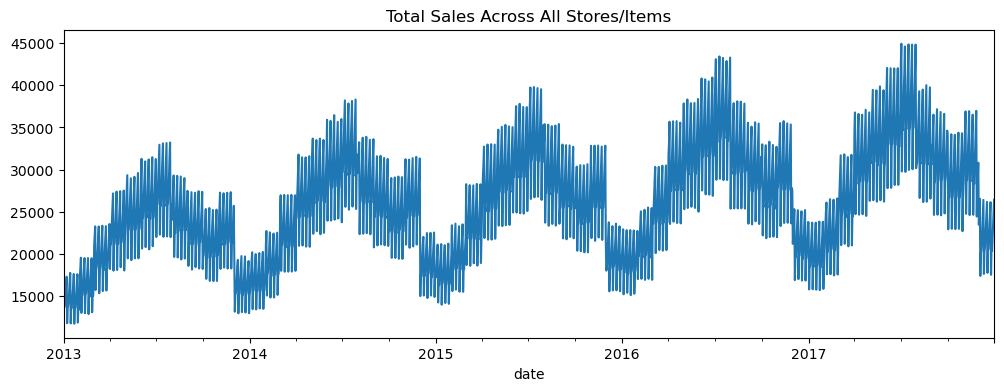

In [4]:
train.groupby("date")["sales"].sum().plot(figsize=(12,4))
plt.title("Total Sales Across All Stores/Items")
plt.show()


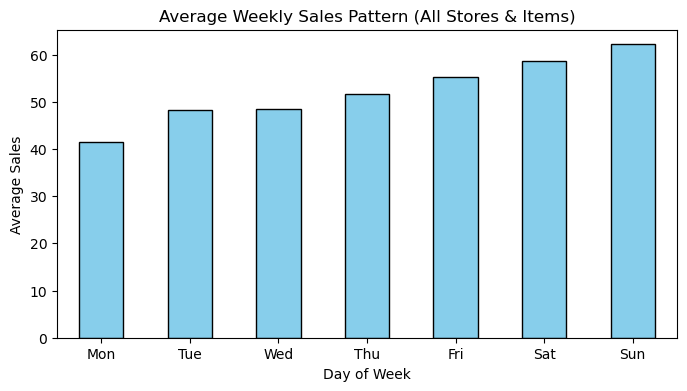

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Add day of week column
train["dow"] = train["date"].dt.dayofweek  # 0=Monday, 6=Sunday

# Average sales by day of week for all stores/items
dow_avg = train.groupby("dow")["sales"].mean()

plt.figure(figsize=(8,4))
dow_avg.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.title("Average Weekly Sales Pattern (All Stores & Items)")
plt.ylabel("Average Sales")
plt.xlabel("Day of Week")
plt.show()


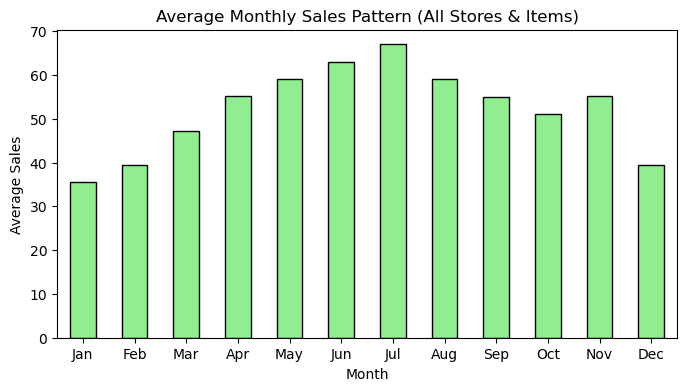

In [6]:
# Add month column
train["month"] = train["date"].dt.month  # 1=Jan ... 12=Dec

# Average sales by month across all stores/items
month_avg = train.groupby("month")["sales"].mean()

plt.figure(figsize=(8,4))
month_avg.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.xticks(range(12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
           rotation=0)
plt.title("Average Monthly Sales Pattern (All Stores & Items)")
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.show()


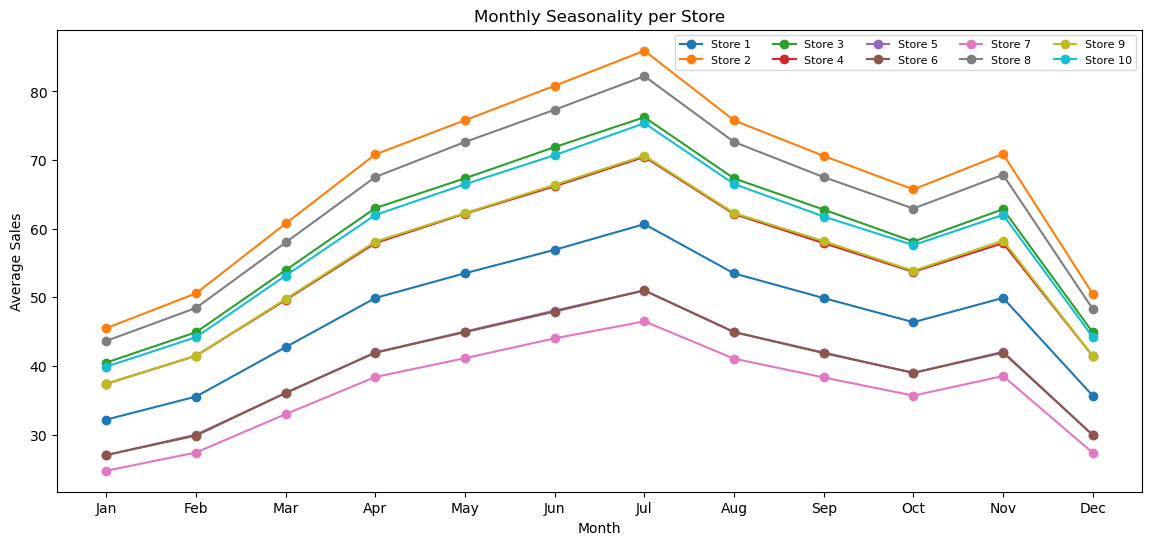

In [7]:
month_store = train.groupby(["store","month"])["sales"].mean().unstack()

plt.figure(figsize=(14,6))
for store in month_store.index:
    plt.plot(range(1,13), month_store.loc[store], marker="o", label=f"Store {store}")

plt.xticks(range(1,13), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("Monthly Seasonality per Store")
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.legend(ncol=5, fontsize=8)
plt.show()


In [ ]:
cutoff_date = pd.Timestamp("2017-09-30")   
valid_start  = cutoff_date + pd.Timedelta(days=1)
valid_end    = pd.Timestamp("2017-12-31")  # Validation period (last 3 months)
test_start   = test["date"].min()
test_end     = test["date"].max()

train_cut = train[train["date"] <= cutoff_date].copy()
valid_cut = train[(train["date"] > cutoff_date) & (train["date"] <= valid_end)].copy()

print("Train cut:", train_cut["date"].min(), "->", train_cut["date"].max())
print("Validation:", valid_cut["date"].min(), "->", valid_cut["date"].max())
print("Test:", test_start, "->", test_end)

Train cut: 2013-01-01 00:00:00 -> 2017-09-30 00:00:00
Validation: 2017-10-01 00:00:00 -> 2017-12-31 00:00:00
Test: 2018-01-01 00:00:00 -> 2018-03-31 00:00:00


In [ ]:
#Creates a complete daily sales timeline for each store–item pair so the model has consistent data to learn and forecast.
groups = {}
all_store_items = train[["store","item"]].drop_duplicates().values.tolist()

for s,i in all_store_items:
    hist = train[(train["store"]==s) & (train["item"]==i)].copy().sort_values("date")
    # full index from earliest train date to test_end
    full_idx = pd.date_range(start=hist["date"].min(), end=test_end, freq="D")
    dfg = pd.DataFrame({"date": full_idx})
    # merge historical sales where present
    dfg = dfg.merge(hist[["date","sales"]], on="date", how="left")
    # mark store/item
    dfg["store"] = s
    dfg["item"] = i
    groups[(s,i)] = dfg

In [ ]:
#This function builds time-based and lag/rolling features (like day, month, lags, moving averages, trends) so the model can capture seasonality, patterns, and recent sales behavior for each store–item pair.
def make_features(df, min_lag=1, max_lag=28):
    # df sorted by date and contain 'sales'
    df = df.copy()
    dt = df["date"]
    df["dow"] = dt.dt.dayofweek.astype("int8")
    df["is_weekend"] = df["dow"].isin([5,6]).astype("int8")
    df["day"] = dt.dt.day.astype("int8")
    df["month"] = dt.dt.month.astype("int8")
    df["year"] = dt.dt.year.astype("int16")
    df["woy"] = dt.dt.isocalendar().week.astype("int16")
    df["quarter"] = dt.dt.quarter.astype("int8")
    # lags
    for L in (1,7,14,28):
        df[f"lag_{L}"] = df["sales"].shift(L)
    df["roll7"] = df["sales"].shift(1).rolling(7, min_periods=1).mean()
    df["roll28"] = df["sales"].shift(1).rolling(28, min_periods=1).mean()
    df["mean7"] = df["sales"].shift(1).rolling(7, min_periods=1).mean()
    df["mean28"] = df["sales"].shift(1).rolling(28, min_periods=1).mean()
    df["trend_7_28"] = df["mean7"] - df["mean28"]
    return df

# Build features for every group
for k, dfg in tqdm(groups.items(), total=len(groups)):
    groups[k] = make_features(dfg)

100%|██████████| 500/500 [00:03<00:00, 136.16it/s]


In [ ]:
#Prepares the training dataset by keeping only rows with enough lag history, selects feature columns, optimizes data types for efficiency, and builds a validation mapping so later the model’s forecasts can be compared against the actual sales for each store–item pair.

train_rows = []
for (s,i), dfg in groups.items():
    mask = (dfg["date"] <= cutoff_date)
    df_train = dfg.loc[mask].copy()
    # only keep rows where we have sufficient lag history (lag_28)
    df_train = df_train[df_train["lag_28"].notna()]
    if df_train.shape[0] == 0:
        continue
    df_train["store"] = s; df_train["item"] = i
    train_rows.append(df_train)

train_df_all = pd.concat(train_rows, ignore_index=True)
train_df_all = train_df_all.dropna(subset=["sales"])  # ensure target present
print("Training rows:", len(train_df_all))

# feature columns
feat_cols = ["store","item","dow","is_weekend","day","month","year","woy","quarter",
             "lag_1","lag_7","lag_14","lag_28","roll7","roll28","trend_7_28"]

# convert dtypes for XGBoost efficiency
train_df_all["store"] = train_df_all["store"].astype("int16")
train_df_all["item"] = train_df_all["item"].astype("int16")
train_df_all[["lag_1","lag_7","lag_14","lag_28","roll7","roll28","trend_7_28"]] = \
    train_df_all[["lag_1","lag_7","lag_14","lag_28","roll7","roll28","trend_7_28"]].astype("float32")

X_train = train_df_all[feat_cols]
y_train = train_df_all["sales"].astype("float32")

valid_map = {}
for (s,i), dfg in groups.items():
    vmask = (dfg["date"] > cutoff_date) & (dfg["date"] <= valid_end)
    valid_map[(s,i)] = dfg.loc[vmask, "date"].tolist()

Training rows: 853000


In [ ]:
#XGBoost Model Training Parameters and Fitting

xgb_params = dict(
    n_estimators=1000,
    verbosity=1,
    objective="reg:squarederror",
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
#Function generates future forecasts day by day for each store–item group: it builds lag/rolling features from past predictions, fills in missing values as predictions are made, and recursively updates the dataset so the model can simulate “future” sales beyond the training data.
def recursive_forecast_group(model, dfg, start_date, end_date, feat_cols):
    df = dfg.copy().set_index("date")
    preds = []
    idxs = pd.date_range(start=start_date, end=end_date, freq="D")
    for current in idxs:
        if current not in df.index:
            row = pd.Series(index=feat_cols, dtype=float)
        else:
            row = df.loc[current, feat_cols].copy()


        for L in (1,7,14,28):
            lag_date = current - pd.Timedelta(days=L)
            row[f"lag_{L}"] = df.at[lag_date, "sales"] if (lag_date in df.index) else np.nan
        window7 = [current - pd.Timedelta(days=d) for d in range(1,8)]
        vals7 = [df.at[d, "sales"] for d in window7 if d in df.index]
        row["roll7"] = np.mean(vals7) if len(vals7)>0 else np.nan
        window28 = [current - pd.Timedelta(days=d) for d in range(1,29)]
        vals28 = [df.at[d, "sales"] for d in window28 if d in df.index]
        row["roll28"] = np.mean(vals28) if len(vals28)>0 else np.nan
        row["mean7"] = row["roll7"]
        row["mean28"] = row["roll28"]
        row["trend_7_28"] = (row["mean7"] - row["mean28"]) if (pd.notna(row["mean7"]) and pd.notna(row["mean28"])) else np.nan

        row["dow"] = current.dayofweek
        row["is_weekend"] = int(current.dayofweek in (5,6))
        row["day"] = current.day
        row["month"] = current.month
        row["year"] = current.year
        row["woy"] = current.isocalendar()[1]
        row["quarter"] = (current.month-1)//3 + 1

        if np.isnan(row[["lag_1","lag_7","lag_14","lag_28","roll7","roll28"]]).any():
            pred = np.nan
        else:
            Xrow = np.array([row[c] for c in feat_cols]).reshape(1,-1)
            pred = model.predict(Xrow)[0]
            if pred < 0: pred = 0.0

        preds.append((current, pred))
        if current not in df.index:
            newrow = pd.Series(index=df.columns, dtype=float)
            newrow["sales"] = pred
            df.loc[current] = newrow
        else:
            df.at[current,"sales"] = pred

    return pd.Series({d:v for d,v in preds})

In [ ]:
#Evaluates the XGBoost model on the validation period: it uses recursive forecasts for each store–item pair, compares them with actual sales, filters out missing values, then calculates MAE, RMSE, MAPE, and RMSLE to measure prediction accuracy and error size.
val_preds = []
val_truth = []

for (s,i), dfg in tqdm(groups.items(), total=len(groups)):
    # if no validation dates for this group, skip
    vdates = valid_map.get((s,i), [])
    if not vdates:
        continue
    start = min(vdates)
    end   = max(vdates)
    # we must ensure that dfg has historical sales up to start-1 (it does)
    ser_pred = recursive_forecast_group(model, dfg, start, end, feat_cols)
    # get actuals from valid_cut for this group
    actuals = valid_cut[(valid_cut["store"]==s) & (valid_cut["item"]==i)].set_index("date")["sales"].reindex(ser_pred.index)
    # keep only dates where both pred and actual exist and pred not nan
    mask = ser_pred.notna() & actuals.notna()
    if mask.sum() == 0:
        continue
    val_preds.extend(ser_pred[mask].values.tolist())
    val_truth.extend(actuals[mask].values.tolist())

# metrics
val_preds = np.array(val_preds)
val_truth = np.array(val_truth)
# clip
val_preds = np.clip(val_preds, 0, None)
val_truth = np.clip(val_truth, 0, None)

mae = mean_absolute_error(val_truth, val_preds)
rmse = np.sqrt(mean_squared_error(val_truth, val_preds))
mape = np.mean(np.abs((val_truth - val_preds) / np.where(val_truth==0, 1, val_truth))) * 100
rmsle = np.sqrt(mean_squared_log_error(val_truth, val_preds))

print("XGB validation → MAE: %.2f, RMSE: %.2f, MAPE: %.2f%%, RMSLE: %.4f" % (mae,rmse,mape,rmsle))

100%|██████████| 500/500 [03:03<00:00,  2.73it/s]

XGB validation → MAE: 5.91, RMSE: 7.66, MAPE: 12.99%, RMSLE: 0.1593


In [ ]:
#Retrains the XGBoost model on all available training data (up to the end of 2017), then generates forecasts for the test set per store–item pair, fills any missing predictions with the average sales.

full_train_rows = []
for (s,i), dfg in groups.items():
    df_full = dfg[dfg["date"] <= valid_end].copy()  # up to 2017-12-31
    df_full = df_full[df_full["lag_28"].notna()]    # require lag_28
    df_full = df_full.dropna(subset=["sales"])
    if df_full.shape[0] == 0:
        continue
    df_full["store"]=s; df_full["item"]=i
    full_train_rows.append(df_full)

full_train_df = pd.concat(full_train_rows, ignore_index=True)
X_full = full_train_df[feat_cols]
y_full = full_train_df["sales"].astype("float32")

model_full = xgb.XGBRegressor(**xgb_params)
model_full.fit(X_full, y_full)

# Forecast test per group
test_preds_rows = []
for (s,i), dfg in tqdm(groups.items(), total=len(groups)):
    # select test subgroup rows
    test_rows = test[(test["store"]==s) & (test["item"]==i)].sort_values("date")
    if test_rows.shape[0] == 0:
        continue
    start = test_rows["date"].min()
    end   = test_rows["date"].max()
    ser_pred = recursive_forecast_group(model_full, dfg, start, end, feat_cols)
    dfp = pd.DataFrame({"date": ser_pred.index, "forecast": ser_pred.values})
    dfp["store"] = s; dfp["item"] = i
    # merge with test rows to maintain id order
    dfp = test_rows.merge(dfp, on=["date","store","item"], how="left")
    test_preds_rows.append(dfp[["id","date","store","item","forecast"]])

test_forecast_df = pd.concat(test_preds_rows, ignore_index=True).sort_values(["id"])
# if any missing, fill with per-series mean or global mean
test_forecast_df["forecast"] = test_forecast_df["forecast"].fillna(train["sales"].mean())



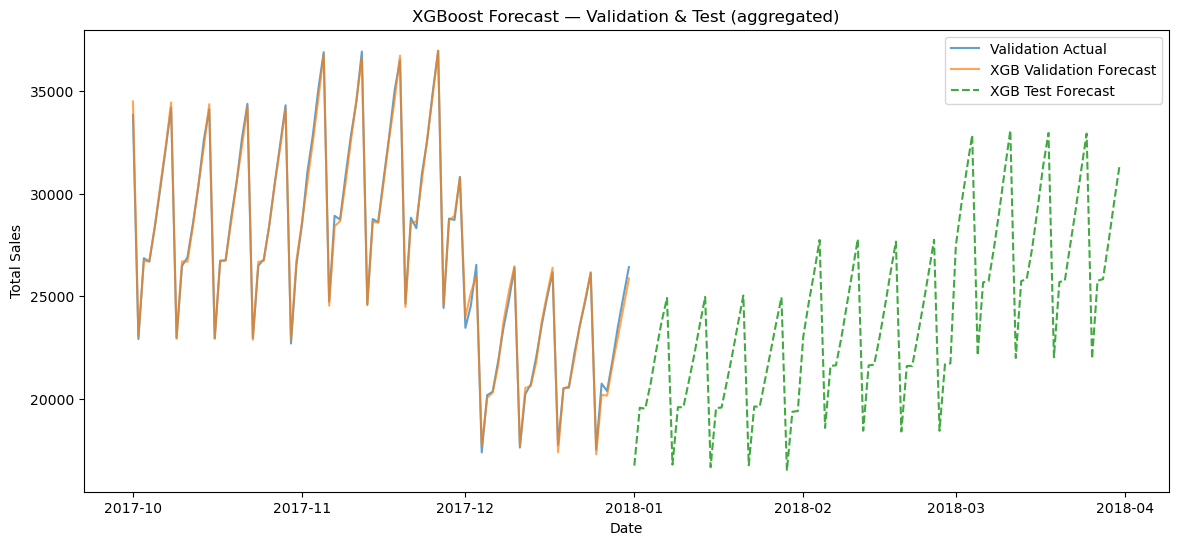

In [ ]:
#PLot the aggregated validation actuals, validation forecasts, and test forecasts over time to visually assess the model’s performance and trends across the validation and test dataset.

valid_dates = sorted(list(set(val for sublist in valid_map.values() for val in sublist)))
agg_val_actual = valid_cut.groupby("date")["sales"].sum().reindex(valid_dates).fillna(0)
val_pred_by_date = {}
for (s,i), dfg in groups.items():
    vdates = valid_map.get((s,i), [])
    if not vdates: continue
    ser_pred = recursive_forecast_group(model, dfg, min(vdates), max(vdates), feat_cols)
    for d,v in ser_pred.items():
        val_pred_by_date.setdefault(d,0.0)
        if not np.isnan(v): val_pred_by_date[d]+=v

agg_val_pred = pd.Series(val_pred_by_date).sort_index()
agg_test_pred = test_forecast_df.groupby("date")["forecast"].sum()

plt.figure(figsize=(14,6))
plt.plot(agg_val_actual, label="Validation Actual", alpha=0.7)
plt.plot(agg_val_pred.reindex(agg_val_actual.index), label="XGB Validation Forecast", alpha=0.7)
plt.plot(agg_test_pred, '--', label="XGB Test Forecast", alpha=0.9)
plt.title("XGBoost Forecast — Validation & Test (aggregated)")
plt.xlabel("Date"); plt.ylabel("Total Sales")
plt.legend(); plt.show()

In [ ]:
# After training your model
model_full.save_model("xgb_forecast.json")

# To reload the model
import xgboost as xgb
model_loaded = xgb.XGBRegressor()
model_loaded.load_model("xgb_forecast.json")
